## **Install Library**

In [1]:
!pip -q install timm 

     |████████████████████████████████| 509 kB 24.0 MB/s 


## **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Library & Set up**

In [3]:
import torch
import timm
import os
import random

import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from datetime import datetime

%matplotlib inline

!cp /content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/data/data.zip .
!cp /content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/sample_submission.csv .
!unzip -qq data.zip -d .

In [4]:
def set_random_seed(random_state=0):
  torch.manual_seed(random_state)
  torch.cuda.manual_seed(random_state)
  np.random.seed(random_state)
  random.seed(random_state)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## **Data Preprocessing**
1. Define Dataset Class
2. Add Data Augmentation
3. Make Train/Valid Dataset & DataLoader

### Define Dataset Class


In [5]:
class CustomSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.indices = self.subset.indices
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)


class TestDataset(Dataset):
    def __init__(self, root='./test', transform=None):
        self.root = root
        self.data = os.listdir(self.root)
        self.data = sorted(self.data)
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.data[idx]))
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.data)


### Add Data Augmentation : Cutout

In [6]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

### Make Dataset & DataLoader

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset # create two datasets from all_data

def get_loaders(path='./train', batch_size=32, n_splits=1, test_size=0.1, random_state=0, transform=None):
    if transform is None:
        transform = {'train' : None, 'valid' : None}
        
    all_data = ImageFolder(root='./train')
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    indices = list(range(len(all_data)))
    y_all_data = [y for _, y in all_data]

    for train_index, val_index in sss.split(indices, y_all_data):
        pass

    train_subset = Subset(all_data, train_index)
    test_subset = Subset(all_data, val_index)

    train_data = CustomSubset(train_subset, transform['train'])
    test_data = CustomSubset(test_subset, transform['valid'])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return all_data, train_data, train_loader, test_loader

## **Model Parameter Check**

In [20]:
# for checking the number of parameters
# do not modify below
def param_check(model):
    total = 0
    for param in model.parameters():
        total += torch.numel(param)

    print(f'# of parameters : {total}\n')
    return total < 15000000

## **Define Main Function**

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, print_every=10, scheduler=None, path2weight=None):
    if path2weight == None:
      raise Exception("model의 가중치 파일을 저장할 경로를 지정해주세요.")

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    best_acc = -np.inf
    start_time = datetime.now()
    try:
        for epoch in range(num_epochs):
            train_loss = 0
            train_acc = 0
            processed = 0
            model.train()
            # training step
            print(f'Epoch [{epoch}] Learning Rate : {get_lr(optimizer)}')
            for i, (data, label) in enumerate(train_loader):
                data, label = data.to(device), label.to(device)
                pred = model(data)
                loss = criterion(pred, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                train_acc += torch.sum(pred.argmax(1) == label).item()
                processed += data.size(0)
                if (i % print_every == 0) or (i == len(train_loader) - 1):
                    print(
                        f'Epoch [{epoch}/{num_epochs - 1}]({(i + 1) / len(train_loader) * 100:.2f}%)\t\
                        train loss: {train_loss / processed:.4f}\t\
                        train acc: {train_acc / processed * 100:.4f}%\t\
                        time elapsed: {datetime.now() - start_time}'
                        )
            train_losses.append(train_loss / processed)
            train_accs.append(train_acc / processed)
            print("="*100)

            # validation step
            valid_loss = 0
            valid_acc = 0
            processed = 0
            model.eval()
            with torch.no_grad():
                for i, (data, label) in enumerate(valid_loader):
                    data, label = data.to(device), label.to(device)
                    pred = model(data)
                    loss = criterion(pred, label)
                    valid_loss += loss.item() * data.size(0)
                    valid_acc += torch.sum(pred.argmax(1) == label).item()
                    processed += data.size(0)
                    if (i % print_every == 0) or (i == len(valid_loader) - 1):
                        print(
                            f'Epoch [{epoch}/{num_epochs - 1}]({(i + 1) / len(valid_loader) * 100:.2f}%)\t\
                            valid loss: {valid_loss / processed:.4f}\t\
                            valid acc: {valid_acc / processed * 100:.4f}%\t\
                            time elapsed: {datetime.now() - start_time}'
                            )
                if valid_acc / processed > best_acc:
                    best_acc = valid_acc / processed
                    torch.save(model.state_dict(), f'{path2weight}_best_gc01.pth')
                    print("Best weight saved!!")
                
                torch.save(model.state_dict(), f'{path2weight}_last_gc01.pth')
                valid_losses.append(valid_loss / processed)
                valid_accs.append(valid_acc / processed)
            print("="*100)
            if scheduler is not None:
                scheduler.step(best_acc)
        return train_losses, train_accs, valid_losses, valid_accs, best_acc
    except KeyboardInterrupt:
        return train_losses, train_accs, valid_losses, valid_accs, best_acc

In [23]:
def main(cfg=None, trial=None):
  if cfg is None:
    cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'batch_size' : 128,
            'n_epochs' : 85,
            'seed' : 121,
            'n_splits' : 1,
            'test_size' : 0.05,
            'cutout' : True,
            'model_name' : 'efficientnet_lite0',
            'num_classes' : 120,
            'log_interval' : 50,
            #'save_model' : False,
            'lr' : 0.0033,
            'weight_decay' :  5.3e-4,
            'momentum': 0.9,
            'optimizer' : optim.Adam,
            'scheduler' : optim.lr_scheduler.ReduceLROnPlateau,
            'path2weight' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/weights/',
            'path2submit' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/',
          }

  ######################################## train ########################################
  transform = {
    'train': transforms.Compose([transforms.Resize((256, 256)),
                                 #transforms.CenterCrop((256)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
             
    'valid': transforms.Compose([transforms.Resize((256, 256)),
                                # transforms.CenterCrop((112, 112)),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
  }
  if cfg['cutout']:
    transform['train'].transforms.append(Cutout(n_holes=2, length=48))

  try:
    set_random_seed(cfg['seed'])
    _, _, train_loader, valid_loader = get_loaders(batch_size=cfg['batch_size'], n_splits=cfg['n_splits'], test_size=cfg['test_size'], transform = transform)
    model = timm.create_model(cfg['model_name'], pretrained=False, num_classes=cfg['num_classes']).to(cfg['device'])

    param_check(model)

    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(cfg['device'])
    scheduler = cfg['scheduler'](optimizer, mode='max', factor=0.5, patience=6, verbose=True)   # mode='max'로 해야하지않나?, metric: accr대신 loss로 하자.

    # PATH Setting
    path2weight = cfg['path2weight']+cfg['model_name']
    path2submit = cfg['path2submit']+cfg['model_name']+'_gc01.csv'

    train_losses, train_accs, valid_losses, valid_accs, best_acc \
    = train(model, criterion, optimizer, train_loader, valid_loader,num_epochs=cfg['n_epochs'],\
            device=cfg['device'], print_every=cfg['log_interval'], scheduler=scheduler, path2weight=path2weight)
        
    ####################################### test ########################################
    test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                         #transforms.CenterCrop((112, 112)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    test_data = TestDataset(root='./test', transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=cfg['batch_size'], shuffle=False)

    model.load_state_dict(torch.load(f'{path2weight}_best_gc01.pth'))
    model.to(cfg['device'])
    preds = test(model, test_loader, cfg['device'])
    submission = pd.read_csv('sample_submission.csv')
    submission['Category'] = preds.cpu().numpy()
    submission.to_csv(path2submit, index=False)

    return train_losses, train_accs, valid_losses, valid_accs
  except KeyboardInterrupt:
    return train_losses, train_accs, valid_losses, valid_accs

model1: test_acc 65.29%

In [ ]:
cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'batch_size' : 128,
            'n_epochs' : 110,
            'seed' : 666,
            'n_splits' : 1,
            'test_size' : 0.1,
            'cutout' : True,
            'model_name' : 'efficientnet_lite0',
            'num_classes' : 120,
            'log_interval' : 50,
            #'save_model' : False,
            'lr' : 0.005,
            'weight_decay' :  5e-4,
            'momentum': 0.9,
            'optimizer' : optim.Adam,
            'scheduler' : optim.lr_scheduler.ReduceLROnPlateau,
            'path2weight' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/weights/',
            'path2submit' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/',
          }

# 변경 1
# main() 함수의 scheduler parameter가 아래와 같음
# scheduler = cfg['scheduler'](optimizer, mode='min', factor=0.55, patience=7, verbose=True)

# 변경 2
# train() 함수의 74줄이 아래와 같이 변경됨
# scheduler.step(valid_loss / processed)

train_losses, train_accs, valid_losses, valid_accs = main(cfg=cfg)

model2: valid_acc 67.3817%

In [ ]:
cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'batch_size' : 128,
            'n_epochs' : 100,
            'seed' : 0,
            'n_splits' : 1,
            'test_size' : 0.1,
            'cutout' : True,
            'model_name' : 'efficientnet_lite0',
            'num_classes' : 120,
            'log_interval' : 50,
            #'save_model' : False,
            'lr' : 0.003,
            'weight_decay' :  5e-4,
            'momentum': 0.9,
            'optimizer' : optim.Adam,
            'scheduler' : optim.lr_scheduler.ReduceLROnPlateau,
            'path2weight' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/weights/',
            'path2submit' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/',
          }

# 변경 1
# main() 함수의 transform에서 cutout의 parameter가 아래와 같음
# transform['train'].transforms.append(Cutout(n_holes=2, length=48))

# 변경 2
# main() 함수의 scheduler parameter가 아래와 같음
# scheduler = cfg['scheduler'](optimizer, mode='min', factor=0.5, patience=6, verbose=True)

# 변경 3
# train() 함수의 74줄이 아래와 같이 변경됨
# scheduler.step(valid_loss / processed)

train_losses, train_accs, valid_losses, valid_accs = main(cfg=cfg)

model3: valid_acc 66.7767%

In [ ]:
cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'batch_size' : 128,
            'n_epochs' : 100,
            'seed' : 0,
            'n_splits' : 1,
            'test_size' : 0.05,
            'cutout' : True,
            'model_name' : 'efficientnet_lite0',
            'num_classes' : 120,
            'log_interval' : 50,
            #'save_model' : False,
            'lr' : 0.0033,
            'weight_decay' :  5.3e-4,
            'momentum': 0.9,
            'optimizer' : optim.Adam,
            'scheduler' : optim.lr_scheduler.ReduceLROnPlateau,
            'path2weight' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/weights/',
            'path2submit' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/',
          }

# 변경 1
# main() 함수의 transform에서 cutout의 parameter가 아래와 같음
# transform['train'].transforms.append(Cutout(n_holes=3, length=36))

# 변경 2
# main() 함수의 scheduler parameter가 아래와 같음
# scheduler = cfg['scheduler'](optimizer, mode='min', factor=0.5, patience=6, verbose=True)

# 변경 3
# train() 함수의 74줄이 아래와 같이 변경됨
# scheduler.step(valid_loss / processed)

train_losses, train_accs, valid_losses, valid_accs = main(cfg=cfg)

model4: valid_acc 73.5974%

In [ ]:
train_losses, train_accs, valid_losses, valid_accs = main()

# of parameters : 3524728

Epoch [0] Learning Rate : 0.0033
Epoch [0/84](0.74%)	                        train loss: 4.9289	                        train acc: 0.0000%	                        time elapsed: 0:00:08.571013
Epoch [0/84](37.78%)	                        train loss: 5.0250	                        train acc: 2.2978%	                        time elapsed: 0:01:10.779132
Epoch [0/84](74.81%)	                        train loss: 4.6920	                        train acc: 3.3957%	                        time elapsed: 0:02:09.556019
Epoch [0/84](100.00%)	                        train loss: 4.5717	                        train acc: 3.9199%	                        time elapsed: 0:02:50.723688
Epoch [0/84](12.50%)	                            valid loss: 4.6259	                            valid acc: 5.4688%	                            time elapsed: 0:02:51.433722
Epoch [0/84](100.00%)	                            valid loss: 4.5956	                            valid acc: 2.2002%	            

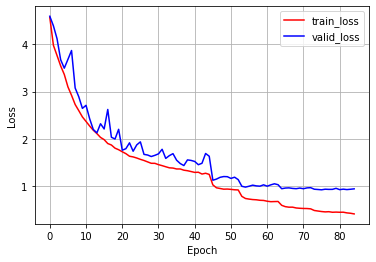

In [ ]:
plt.xticks(np.arange(0, 111, 10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(train_losses)), train_losses, label='train_loss', color='red')
plt.plot(range(len(valid_losses)), valid_losses, label='valid_loss', color='blue')
plt.legend()
plt.grid(True)
plt.show()

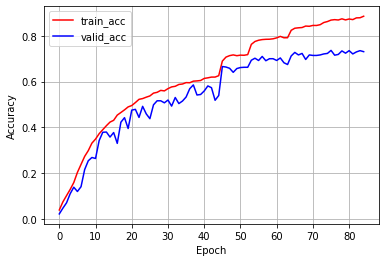

In [ ]:
plt.xticks(np.arange(0, 111, 10))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(len(train_accs)), train_accs, label='train_acc', color='red')
plt.plot(range(len(valid_accs)), valid_accs, label='valid_acc', color='blue')
plt.legend()
plt.grid(True)
plt.show()

## **Test**

In [34]:
def test(model, test_loader, device):
    preds = None
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            if preds is None:
                preds = model(data)
            else:
                preds = torch.cat((preds, model(data)), dim=0)
    return preds

In [30]:
cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
        'model_name' : 'efficientnet_lite0',
        'num_classes' : 120,
        'path2weight' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/weights/save_best/',
        'path2submit' : '/content/drive/Shareddrives/KHU/Kaggle/D.COM_AI_COMPETITION_1th/submission/',
       }

path2weight = cfg['path2weight']+cfg['model_name']
path2submit = cfg['path2submit']+cfg['model_name']+'_cross_val.csv'

### Ensemble & Hard Voting

In [35]:
test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_data = TestDataset(root='./test', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

preds_list=[]

for fold in [2,5,6,7]:
    model = timm.create_model(cfg['model_name'], pretrained=False, num_classes=cfg['num_classes']).to(cfg['device'])
    param_check(model)
    model.load_state_dict(torch.load(f'{path2weight}_gc01_save{fold}.pth'))
    preds = test(model, test_loader, cfg['device'])
    preds = preds.view(preds.shape[0], preds.shape[1], 1).cpu()
    preds_list.append(preds)

preds_arr = np.concatenate(preds_list, axis=2)
preds_mean = preds_arr.mean(axis=2)
preds_mean = torch.from_numpy(preds_mean)
preds = torch.argmax(preds_mean, 1)

submission = pd.read_csv('sample_submission.csv')
submission['Category'] = preds.cpu().numpy()
submission.to_csv(path2submit, index=False)
print("ensemble finish.")

# of parameters : 3524728

# of parameters : 3524728

# of parameters : 3524728

# of parameters : 3524728

ensemble finish.
